This is the notebook to run the seq2seq network. It starts with a preprocessed file with calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.7.1 Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker
#now we bring in the keras tensorflow model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense, LSTM, SimpleRNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model

import tensorflow.keras
import pydot
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot
tensorflow.keras.utils.pydot = pydot
from tensorflow.keras.utils import plot_model    


from math import pow, floor
import time

In [2]:
#load the data
data = pd.read_csv('2016_ring66_comb.csv', index_col=0)

data.index = pd.to_datetime(data.index)

In [3]:
#lets do some massaging
import traces as ts

#average over 6 hours
sampling=3600
avg_window = sampling*6
#windows are in seconds
calib_50 = ts.TimeSeries(data['calib_50'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
calib_10 = ts.TimeSeries(data['calib_10'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
calib_90 = ts.TimeSeries(data['calib_90'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
int_lumi = ts.TimeSeries(data['int_lumi'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

#take the differences
calib_10 = calib_10.diff().dropna()
calib_50 = calib_50.diff().dropna()
calib_90 = calib_90.diff().dropna()
int_lumi = int_lumi.diff().dropna()

In [4]:
#build the new dataframe
frame = {'int_lumi':int_lumi,'calib_50':calib_50,'calib_90':calib_90,'calib_10':calib_10}

massaged_data = pd.DataFrame(frame)

massaged_data

,int_lumi,calib_50,calib_90,calib_10
2016-03-10 12:43:44,0.0,0.000013,-0.000061,0.000111
2016-03-10 13:43:44,0.0,0.000008,-0.000036,0.000067
2016-03-10 14:43:44,0.0,0.000005,-0.000024,0.000044
2016-03-10 15:43:44,0.0,0.000026,-0.000121,0.000222
2016-03-10 16:43:44,0.0,0.000000,0.000000,0.000000
...,...,...,...,...
2016-12-05 10:43:44,0.0,0.000000,0.000000,0.000000
2016-12-05 11:43:44,0.0,-0.000632,-0.000779,-0.000346
2016-12-05 12:43:44,0.0,-0.000833,-0.001623,0.000512
2016-12-05 13:43:44,0.0,-0.000831,-0.001622,0.000511


In [5]:
#let's split off the data with the last 1/10ths for testing
int(massaged_data.shape[0]/10)

648

In [6]:
train = massaged_data.iloc[:massaged_data.shape[0]-int(massaged_data.shape[0]/10),:]
test = massaged_data.iloc[-int(massaged_data.shape[0]/10):,:]

In [7]:
#for now we'll only train on the median
train = train.drop(['calib_90','calib_10'],axis=1)
test = test.drop(['calib_90','calib_10'],axis=1)

In [8]:
#now we will scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_scaler = StandardScaler() #we'll use the y-scaler later
y_scaler.fit(train[['calib_50']])
train[['calib_50', 'int_lumi']] = scaler.fit_transform(train)
train.describe()


,int_lumi,calib_50
count,5.447000e+03,5.835000e+03
mean,-1.566353e-16,1.651309e-16
std,1.000092e+00,1.000086e+00
min,-5.880146e+00,-4.707854e+00
25%,-1.442933e-01,2.315707e-08
50%,4.354416e-02,1.704243e-07
75%,4.335568e-01,1.429298e-02
max,6.659243e+00,4.707854e+00


In [9]:
test[['calib_50', 'int_lumi']] = scaler.transform(test)
test.describe()

,int_lumi,calib_50
count,641.000000,6.480000e+02
mean,0.018794,2.316779e-07
std,1.105066,3.681483e-06
min,-7.324370,-2.249694e-05
25%,-0.047608,2.315741e-08
50%,0.044480,2.736917e-08
75%,0.132791,5.241476e-07
max,7.649788,2.254337e-05


In [10]:
#build the data
HORIZON = 24 #24hrs
train_shifted = train.copy()
calibration_shifted = train_shifted[['calib_50']]
lumi_shifted = train_shifted[['int_lumi']]
for t in range(1, HORIZON):
    calibration_shifted['calib_50+'+str(t)] = calibration_shifted['calib_50'].shift(-t, freq='H')
    lumi_shifted['int_lumi+'+str(t)] = lumi_shifted['int_lumi'].shift(-t, freq='H')
#each row in each of the dataframes corresponds to 24hrs of data
target_seq = calibration_shifted.dropna()
input_seq = lumi_shifted.dropna()

#convert to np array
target_np = target_seq.to_numpy() #[row:column]
input_np = input_seq.to_numpy()

#we also want to create an 'over by 1' version of the target sequence to train the decoder
#we'll stick with a 0 padding for now
target_np_shifted = np.pad(target_np, ((0,0),(1,0)), mode='constant')[:,0:-1]

In [11]:
batch_size = 64  # Batch size for training.
epochs = 1000  # Number of epochs to train for.
latent_dim = 64  # Latent dimensionality of the encoding space.

#Define an input sequence and process it.
encoder_inputs = Input(shape=(None, 1))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, 1))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1, activation="linear")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [12]:
model.compile(
    optimizer="rmsprop", loss=MeanSquaredError(), #metrics=["accuracy"]
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  16896       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 64), ( 16896       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [14]:
decoder_target_data = target_np
encoder_input_data = input_np
decoder_input_data = target_np_shifted

In [15]:
#training setup
# learning rate schedule
def my_lr(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 200
    lrate = initial_lrate * pow(drop, floor((1+epoch)/epochs_drop))
    return initial_lrate

def my_loss_fn(y_true, y_pred):
    return abs((y_true - y_pred) ** 2.0)

earlystop = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=15,restore_best_weights=True)
lrate = LearningRateScheduler(my_lr)

In [16]:
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[earlystop, lrate],
)
# Save model
model.save("s2s")

Epoch 1/1000
62/62 [==============================] - 6s 40ms/step - loss: 1.0198 - val_loss: 0.0468
Epoch 2/1000
62/62 [==============================] - 2s 28ms/step - loss: 0.8142 - val_loss: 0.0476
Epoch 3/1000
62/62 [==============================] - 2s 28ms/step - loss: 0.7855 - val_loss: 0.0494
Epoch 4/1000
62/62 [==============================] - 2s 28ms/step - loss: 0.7655 - val_loss: 0.0467
Epoch 5/1000
62/62 [==============================] - 2s 27ms/step - loss: 0.7482 - val_loss: 0.0461
Epoch 6/1000
62/62 [==============================] - 2s 28ms/step - loss: 0.7313 - val_loss: 0.0469
Epoch 7/1000
62/62 [==============================] - 2s 25ms/step - loss: 0.7126 - val_loss: 0.0518
Epoch 8/1000
62/62 [==============================] - 2s 25ms/step - loss: 0.6957 - val_loss: 0.0481
Epoch 9/1000
62/62 [==============================] - 1s 24ms/step - loss: 0.6831 - val_loss: 0.0554
Epoch 10/1000
62/62 [==============================] - 2s 26ms/step - loss: 0.6711 - val_lo

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [17]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
#model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [18]:
def decode_sequence(input_seq):
 #   print('input_seq:\n',input_seq)
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
 #   print('states_value:\n',states_value)
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    
    decoded_sequence = []
    
    target_seq = np.zeros(1)
    
    #print([target_seq])
    #print(states_value)
    for ts in range(0, HORIZON):
        output_value, h, c = decoder_model.predict([target_seq] + states_value)
        decoded_sequence.append(output_value[0,0,0])
        # Update states
        states_value = [h, c]
        target_seq[0] = output_value
    
    return decoded_sequence

In [19]:
decoded_sequences = []
target_sequences = []
max_seq = 2400
for seq_index in range(0,max_seq,HORIZON):
  #  print("========================================")
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    target_seq = decoder_target_data[seq_index: seq_index + 1]
 #   print("Input sequence:\n", input_seq)
    decoded_sequence = decode_sequence(input_seq)
 #  print("--------")
 #  print("Decoded sequence:\n", decoded_sequence)
 #   print("--------")
 #  print("Target sequence:\n", target_seq[0])
    decoded_sequences = np.concatenate((decoded_sequences, decoded_sequence))
    target_sequences = np.concatenate((target_sequences, target_seq[0]))


In [20]:
results_df = train.copy().iloc[:max_seq]
results_df['target_sequences'] = target_sequences
results_df['decoded_sequences'] = decoded_sequences

In [21]:
results_df.iloc[2000] #the target_sequences is a sanity check...

int_lumi            -0.451160
calib_50             0.015216
target_sequences     0.015216
decoded_sequences    0.100955
Name: 2016-06-01 20:43:44, dtype: float64

In [22]:
results_df = results_df[results_df.index < '2018-09-12 00:00:00'] #something goofy happens after...

TypeError: twinx() got an unexpected keyword argument 'zorder'

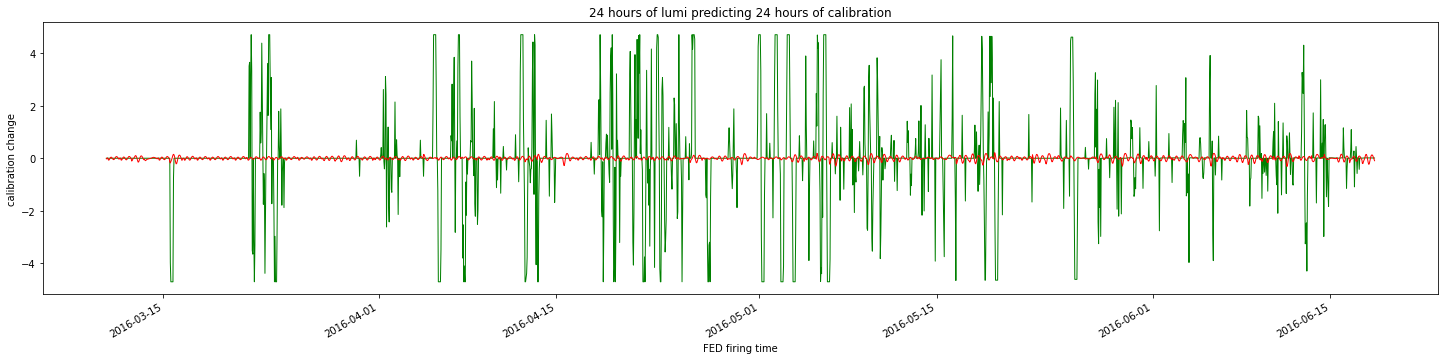

In [28]:
#lets plot the results

fig, ax = plt.subplots(figsize=(25,5))

ax.set_title('{T:.0f} hours of lumi predicting {T:.0f} hours of calibration'.format(T=HORIZON))
ax.set_ylabel('calibration change')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(results_df.index, results_df.target_sequences, 
         label='target median calibration', color='green', linewidth=1, linestyle='solid')
ax.plot(results_df.index, results_df.decoded_sequences, 
         label='predicted median calibration', color='red', linewidth=1, linestyle='solid')
#lumi data on alternate y axis
ax2 = ax.twinx(zorder=-1)
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(results_df.index, results_df.int_lumi, 
         label='lumi', color='cornflowerblue', linewidth=2, linestyle='dashed')

#legend
fig.legend(ncol=1, loc = (0.8,0.2))
fig.show()